In [2]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import datasets,transforms
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(32*7*7, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cpu()
        self.N.scale = self.N.scale.cpu()
        self.kl = 0
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        logvar = self.linear3(x).to(device)
        sigma = (torch.exp(logvar)**0.5).to(device)

        z = (mu + sigma*self.N.sample(mu.shape)).to(device)
        self.kl = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

        return z

class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*7*7),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,out_channels=16, kernel_size=3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    train_loss = 0.0
    i = 0
    for x, _ in dataloader:
        i += 1
        x = x.to(device)
        x_hat = vae(x.to(device))
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 5:
          print('\t partial train loss (single batch): %f' % (loss.item()))

        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

def test_epoch(vae, device, dataloader):
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            encoded_data = vae.encoder(x)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
transforms = transforms.Compose([
   transforms.Resize(64),
   transforms.CenterCrop(64),
   transforms.Grayscale(num_output_channels=1),
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,))
])

train_path = "data/train"
trainset = ImageFolder(
    root=train_path,
    transform=transforms,
)

test_path = "data/test"
testset = ImageFolder(
    root=test_path,
    transform=transforms,
)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

In [7]:
sample = next(iter(train_loader))

In [8]:
print(sample[0].shape)
rd = torch.rand((64,1,64,64), dtype=torch.float32)
print(rd.shape)

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


1585


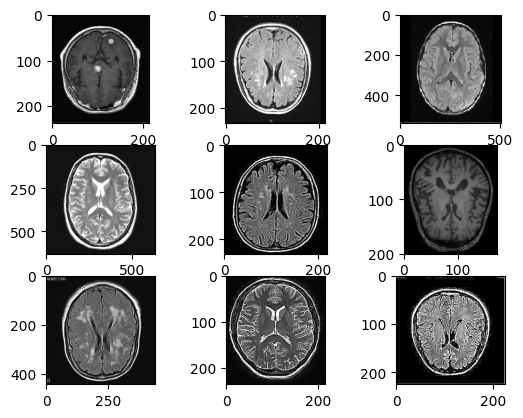

In [14]:
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image
pth_to_imgs = "data/train/notumor"
imgs = glob.glob(os.path.join(pth_to_imgs, "*"))

print(len(imgs))

for i in range(9):
   plt.subplot(3, 3, i+1)
   img = Image.open(imgs[i])
   plt.imshow(img)

plt.show()

In [9]:
lr = 0.00001
step_size = 30
gamma = 0.01
total_epoch = 1

torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d).to(device)
print(f'Selected device: {device}')
vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=1568, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=1568, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=

In [10]:
save_path = "brain_notumor_epoch30.pth"
lr = 1e-3
num_epochs = 30
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
for epoch in range(num_epochs):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,test_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

torch.save(vae.state_dict(),save_path)

	 partial train loss (single batch): 320811.593750
	 partial train loss (single batch): 319579.750000
	 partial train loss (single batch): 310126.843750
	 partial train loss (single batch): 325472.375000
	 partial train loss (single batch): 304221.093750
	 partial train loss (single batch): 304576.187500
	 partial train loss (single batch): 314690.500000
	 partial train loss (single batch): 302877.468750
	 partial train loss (single batch): 292133.562500
	 partial train loss (single batch): 290874.500000
	 partial train loss (single batch): 294298.781250
	 partial train loss (single batch): 293780.906250
	 partial train loss (single batch): 266897.031250
	 partial train loss (single batch): 254342.765625
	 partial train loss (single batch): 293779.218750
	 partial train loss (single batch): 290864.625000
	 partial train loss (single batch): 291826.250000
	 partial train loss (single batch): 286598.187500
	 partial train loss (single batch): 275886.312500
	 partial train loss (single ba

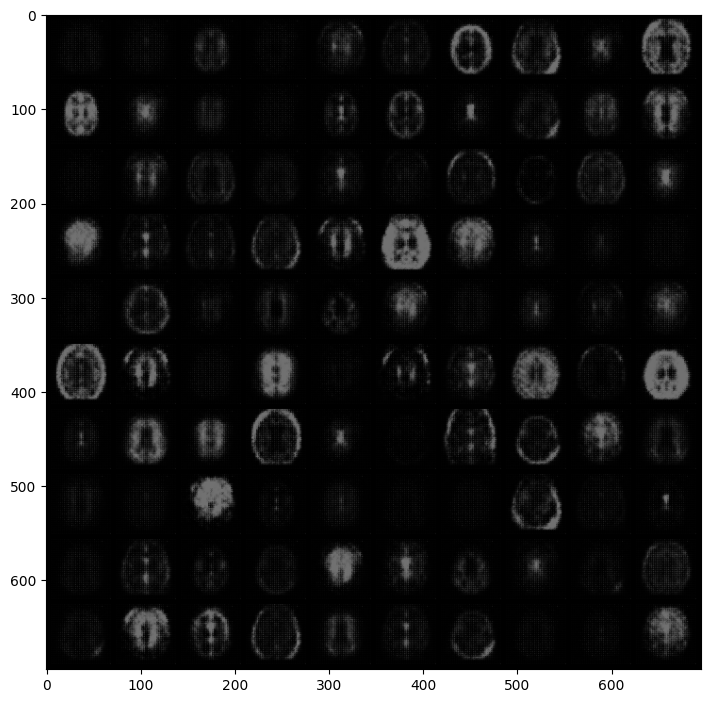

In [11]:
with torch.no_grad():
    vae.load_state_dict(torch.load(save_path))

    latent = torch.randn(128, d, device=device)

    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()